In [ ]:
import requests
import pandas as pd
from datetime import datetime

# Definir la clave de la API y la URL base de FRED
api_key = ''
series_id = 'CPIAUCSL'  # ID de la serie del índice de precios al consumidor de EE.UU.
url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'

# Obtener los datos desde la API
response = requests.get(url)
data = response.json()

# Convertir los datos en un DataFrame de pandas
inflation_data = pd.DataFrame(data['observations'])
inflation_data['date'] = pd.to_datetime(inflation_data['date'])

# Convertir la columna 'value' a numérico, reemplazando errores por NaN
inflation_data['value'] = pd.to_numeric(inflation_data['value'], errors='coerce')

# Eliminar filas donde 'value' no es numérico (NaN)
inflation_data = inflation_data.dropna(subset=['value'])

# Filtrar los últimos 50 años
start_date = datetime.now().year - 50
inflation_data = inflation_data[inflation_data['date'].dt.year >= start_date]

# Asegurarse de que la columna 'value' es numérica y se puede promediar
inflation_data['value'] = inflation_data['value'].astype(float)

# Agrupar por año y calcular el CPI promedio anual
annual_cpi = inflation_data.groupby(inflation_data['date'].dt.year)['value'].mean().reset_index()

# Renombrar columnas
annual_cpi.rename(columns={'date': 'year', 'value': 'avg_cpi'}, inplace=True)

# Calcular la tasa de inflación anual
annual_cpi['inflation_rate'] = annual_cpi['avg_cpi'].pct_change() * 100

# Eliminar el primer año (sin tasa de inflación calculada)
annual_cpi = annual_cpi.dropna()

# Mostrar los datos con la nueva columna de inflación
print(annual_cpi[['year', 'avg_cpi', 'inflation_rate']])

    year     avg_cpi  inflation_rate
1   1975   53.825000        9.141602
2   1976   56.933333        5.774888
3   1977   60.616667        6.469555
4   1978   65.241667        7.629915
5   1979   72.583333       11.253034
6   1980   82.383333       13.501722
7   1981   90.933333       10.378313
8   1982   96.533333        6.158358
9   1983   99.583333        3.159530
10  1984  103.933333        4.368201
11  1985  107.600000        3.527903
12  1986  109.691667        1.943928
13  1987  113.616667        3.578212
14  1988  118.275000        4.100044
15  1989  123.941667        4.791094
16  1990  130.658333        5.419216
17  1991  136.166667        4.215830
18  1992  140.308333        3.041616
19  1993  144.475000        2.969650
20  1994  148.225000        2.595605
21  1995  152.383333        2.805420
22  1996  156.858333        2.936673
23  1997  160.525000        2.337566
24  1998  163.008333        1.547007
25  1999  166.583333        2.193139
26  2000  172.191667        3.366683
2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

inflation_data = annual_cpi[['inflation_rate']].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(inflation_data)

# Crear secuencias para el LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 15  # Número de años de historial para predecir

# Crear las secuencias y los objetivos
X, y = create_sequences(scaled_data, seq_length)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16)

# Predicción de la inflación para los próximos 15 años
forecast_period = 15
forecast = []

# Utilizar la última secuencia de los datos de prueba para hacer predicciones
last_sequence = X_test[-1]

for _ in range(forecast_period):
    # Remodelar la secuencia para que coincida con la forma de entrada del modelo
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # Predecir el siguiente valor de inflación
    next_prediction = model.predict(current_sequence)[0][0]
    # Agregar la predicción a la lista de pronósticos
    forecast.append(next_prediction)
    # Actualizar la última secuencia eliminando el primer elemento y agregando el valor previsto
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Transformación inversa de los valores pronosticados
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0401
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0273
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━

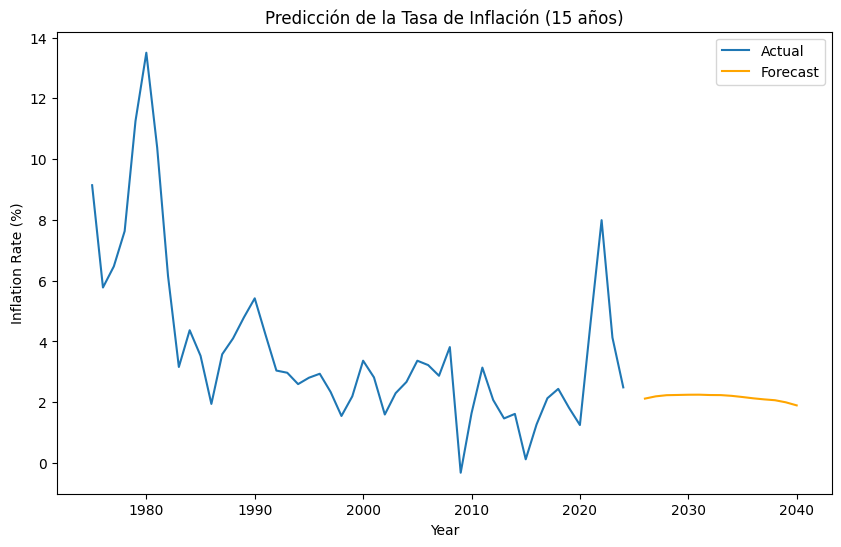

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir el índice de annual_cpi a datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(annual_cpi['year']):
    annual_cpi['year'] = pd.to_datetime(annual_cpi['year'], format='%Y')

# Rango de fechas para los próximos 15 años
forecast_years = pd.date_range(start=annual_cpi['year'].iloc[-1] + pd.DateOffset(years=1), periods=forecast_period, freq='Y')

# Plot de los valores pronosticados
plt.figure(figsize=(10, 6))
plt.plot(annual_cpi['year'], annual_cpi['inflation_rate'], label='Actual')

# Plot de las predicciones futuras
plt.plot(forecast_years, forecast, label='Forecast', color='orange')

plt.title('Predicción de la Tasa de Inflación (15 años)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()

In [ ]:
# Predicciones en formato tabular
forecast_final = np.ravel(forecast)  # Aplana las predicciones para crear una sola lista
forecast_final_df = pd.DataFrame({
    "Year": forecast_years.year,   # Extraer solo el año de forecast_years
    "Inflation_Rate": forecast_final  # Predicciones de inflación
})

# Mostrar la tabla con las predicciones de los próximos 15 años
print(forecast_final_df)


    Year  Inflation_Rate
0   2025        2.118993
1   2026        2.193194
2   2027        2.231104
3   2028        2.238422
4   2029        2.246090
5   2030        2.247927
6   2031        2.236615
7   2032        2.234019
8   2033        2.209602
9   2034        2.171049
10  2035        2.128103
11  2036        2.093278
12  2037        2.065275
13  2038        1.996536
14  2039        1.895922


In [ ]:
# Redondear las tasas de inflación a un número fijo de decimales, si es necesario
forecast_final_df['Inflation_Rate'] = forecast_final_df['Inflation_Rate'].round(4)  # Redondear a 4 decimales

# Guardar el DataFrame como un archivo CSV
forecast_final_df.to_csv('predicciones_inflacion.csv', index=False)
